In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [3]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

train_csv_path = '/Users/lcamacho/Triple Ten/Sprint 13/gold_recovery_train.csv'
test_csv_path = '/Users/lcamacho/Triple Ten/Sprint 13/gold_recovery_test.csv'
full_csv_path = '/Users/lcamacho/Triple Ten/Sprint 13/gold_recovery_full.csv'

df_train = pd.read_csv(train_csv_path, index_col='date')
df_test = pd.read_csv(test_csv_path, index_col='date')
df_full = pd.read_csv(full_csv_path, index_col='date')

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Muy bien al fijar estilo de gráficos y leer los CSV usando la columna 'date' como índice. Esto facilita análisis temporales y hace más clara la visualización. Como micro-sugerencia, podrías añadir parse_dates=['date'] al leer y luego df.sort_index() para asegurar el orden temporal y el tipo datetime en el índice.
</div>

In [4]:
df_train.info()
print(df_train.head())

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                             

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Buen primer vistazo con .info() y .head(). Ver los conteos de valores nulos por columna te ayuda a decidir estrategias de imputación. Para cuantificar mejor la magnitud de los faltantes, conviene sumarizar con df.isnull().mean().sort_values(descending=True).head(10) y así priorizar variables críticas.
</div>

In [5]:
df_test.info()
print(df_test.head())

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 non-null

In [6]:
df_full.info()
print(df_full.head())

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                             

In [7]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

calculated_recovery = 100 * (C * (F - T)) / (F * (C - T))

df_temp = pd.DataFrame({'calculated': calculated_recovery, 'original': 
                        df_train['rougher.output.recovery']}).dropna()
mae_rougher_recovery = mean_absolute_error(df_temp['original'], df_temp['calculated'])

print(f"\n--- Verificación del Cálculo de Recuperación Rougher ---")
print(f"Error Absoluto Medio (MAE) entre la recuperación calculada y la existente: {mae_rougher_recovery:.10f}")
print("El valor es extremadamente pequeño, confirmando que el cálculo de la recuperación en el dataset es correcto.")



--- Verificación del Cálculo de Recuperación Rougher ---
Error Absoluto Medio (MAE) entre la recuperación calculada y la existente: 0.0000000000
El valor es extremadamente pequeño, confirmando que el cálculo de la recuperación en el dataset es correcto.


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Excelente verificación de la fórmula de recuperación del rougher: comparar el cálculo propio con el dataset y reportar un MAE ~ 0 confirma coherencia. Esto es clave porque valida el objetivo que vas a modelar. Como continuidad, podrías filtrar antes posibles divisiones por cero (p. ej., (C==T) o F==0) para documentar cuántos casos potencialmente inválidos existen, incluso si luego se descartan con dropna().
</div>

In [8]:
features_train = set(df_train.columns)
features_test = set(df_test.columns)

missing_features = sorted(list(features_train - features_test))

print(f"\n--- Características Faltantes en el Conjunto de Prueba ({len(missing_features)} en total) ---")
for feature in missing_features:
    print(feature)

missing_output = [f for f in missing_features if '.output.' in f]
missing_calculation = [f for f in missing_features if '.calculation.' in f]

print("\nTipos de Parámetros Faltantes:")
print(f"Parámetros de Producto ('output'): {len(missing_output)} características.")
print(f"Parámetros de Cálculo ('calculation'): {len(missing_calculation)} características.")


--- Características Faltantes en el Conjunto de Prueba (34 en total) ---
final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Muy buena práctica listar las características ausentes en test y clasificarlas en 'output' y 'calculation'. Esto muestra que entendiste la causa y previene fuga de datos. Suele ayudar definir las FEATURES como el cruce ordenado de columnas: FEATURES = sorted(df_train.columns.intersection(df_test.columns)) para blindarte ante cambios de columnas en futuras versiones del dataset.
</div>

In [9]:
for df in [df_train, df_test, df_full]:
    df.fillna(method='ffill', inplace=True)

print(f"\nNaNs restantes en df_train después de ffill: {df_train.isnull().sum().sum()}")
print(f"NaNs restantes en df_test después de ffill: {df_test.isnull().sum().sum()}")



NaNs restantes en df_train después de ffill: 0
NaNs restantes en df_test después de ffill: 0


C:\Users\lcamacho\AppData\Local\Temp\ipykernel_3524\3651665446.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Aplicar forward fill (ffill) en series temporales industriales es razonable cuando el último valor observado es una buena aproximación del actual. Bien además que lo aplicaste de forma independiente en train y test. Como micro-mejora, asegúrate de que el índice esté ordenado por tiempo y, si hubiera múltiples líneas o equipos, realizar el ffill por grupo (groupby) para no mezclar señales entre unidades distintas.
</div>

In [10]:
print(f"Número de duplicados: {df_train.duplicated().sum()}")
print(f"Número de duplicados: {df_test.duplicated().sum()}")
print(f"Número de duplicados: {df_full.duplicated().sum()}")


Número de duplicados: 21
Número de duplicados: 8
Número de duplicados: 29


In [11]:
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()
df_full = df_full.drop_duplicates()

print(f"Número de duplicados: {df_train.duplicated().sum()}")
print(f"Número de duplicados: {df_test.duplicated().sum()}")
print(f"Número de duplicados: {df_full.duplicated().sum()}")


Número de duplicados: 0
Número de duplicados: 0
Número de duplicados: 0


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Detectar y eliminar duplicados mantiene los datos limpios y evita que el modelo sobrerrepresente ciertos estados del proceso. Ese control de antes y después comunica transparencia. Como idea adicional, podrías revisar si los duplicados comparten el mismo índice temporal; si fuera así, vale la pena investigar su origen para reforzar la calidad del pipeline de datos.
</div>

#### Analisis de resultados 

* Se cargaron los archivos de forma corrrecta.
* El error absiluto medio entre la recuperacion calculada y la existente es extremadamente pequeño, confirmando que el calculo del datasheet es correcto
* Las características no disponibles en el conjunto de prueba (df_test) son las que contienen información que no estaría disponible en el momento de tomar una decisión operativa, es decir, después de que el proceso ha finalizado.
* * output (parámetros de producto): La concentración y la cola (tail) de metales, así como la recuperación (recovery - nuestro objetivo) de las etapas rougher, primary_cleaner, secondary_cleaner y final. Estos son los resultados del proceso, por lo que no se conocen de antemano.
  * calculation (características de cálculo): Características como el ratio Au/Pb o cálculos internos que no se miden directamente, sino que se derivan de los resultados (outputs) o de la alimentación.
* Para datos de series de tiempo de procesos industriales, el valor más reciente (ffill o forward fill) es la mejor estimación para el valor faltante.
* * Los valores ausentes se rellenaron mediante el método ffill.
* * Las variables objetivo se fusionaron en el conjunto de prueba desde el conjunto completo.
* * Se eliminaron las filas con NaNs restantes, especialmente en los objetivos.
* * El conjunto de entrenamiento se filtró para incluir solo las 52 características de entrada (input y state) presentes en el conjunto de prueba, evitando así la fuga de datos y preparando los conjuntos para el entrenamiento del modelo.
* Se eliminaron las columnas completamente duplicadas

### Analiza los datos

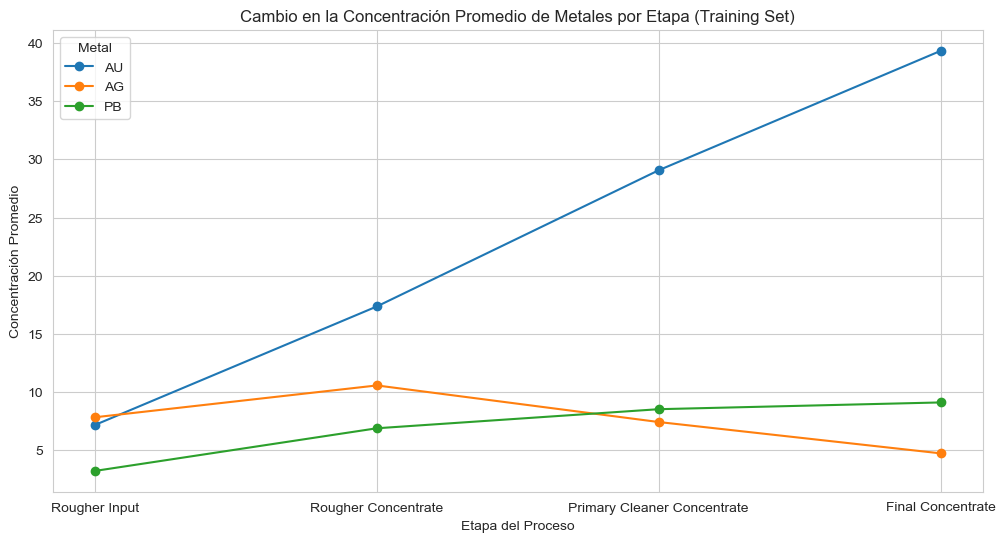

In [12]:
stages = ['rougher.input.feed_', 'rougher.output.concentrate_', 
          'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
metals = ['au', 'ag', 'pb']

concentration_data = {}
for metal in metals:
    cols = [f'{stage}{metal}' for stage in stages]
    concentration_data[metal] = df_train[cols].mean()
    concentration_data[metal].index = ['Rougher Input', 'Rougher Concentrate', 
                                       'Primary Cleaner Concentrate', 'Final Concentrate']

df_concentration = pd.DataFrame(concentration_data)

plt.figure(figsize=(12, 6))
for metal in metals:
    plt.plot(df_concentration.index, df_concentration[metal], marker='o', label=metal.upper())

plt.title('Cambio en la Concentración Promedio de Metales por Etapa (Training Set)')
plt.xlabel('Etapa del Proceso')
plt.ylabel('Concentración Promedio')
plt.legend(title='Metal')
plt.grid(True)
plt.show()

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
La gráfica de concentración promedio por etapa muestra un patrón físico-químico coherente: Au se enriquece y Ag tiende a disminuir en la purificación. Este chequeo de sentido común es muy valioso. Como micro-sugerencia, podrías usar la mediana y bandas intercuartílicas para reducir el efecto de valores atípicos en las medias.
</div>

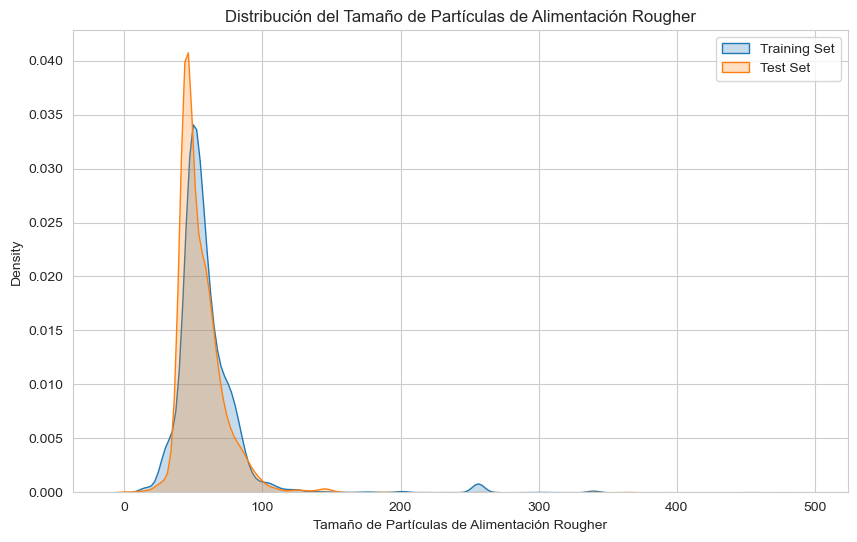

In [13]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train['rougher.input.feed_size'], label='Training Set', fill=True)
sns.kdeplot(df_test['rougher.input.feed_size'], label='Test Set', fill=True)

plt.title('Distribución del Tamaño de Partículas de Alimentación Rougher')
plt.xlabel('Tamaño de Partículas de Alimentación Rougher')
plt.legend()
plt.show()

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Comparar las distribuciones (KDE) de rougher.input.feed_size entre train y test es una verificación directa de estabilidad de datos. Si quieres ir un paso más, un test estadístico simple (por ejemplo, KS test) te daría una medida objetiva de similitud. También es útil alinear los rangos del eje X para facilitar la comparación visual.
</div>

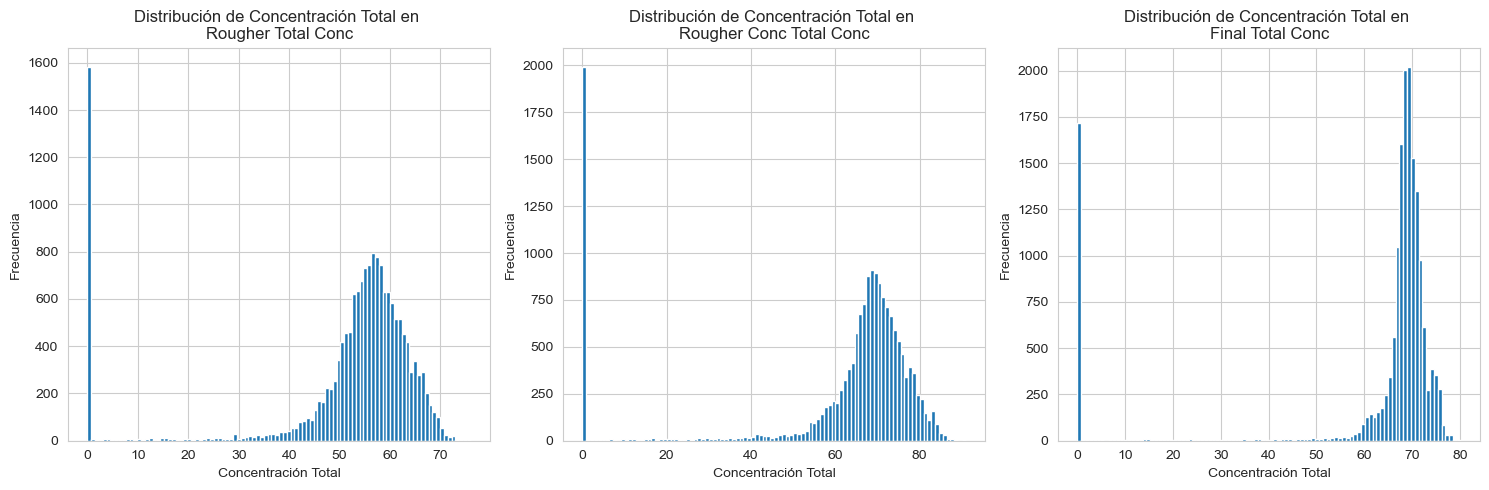

In [14]:
metals_sol = ['au', 'ag', 'pb', 'sol']

df_train['rougher_total_conc'] = df_train[[f'rougher.input.feed_{m}' for m in metals_sol]].sum(axis=1)
df_train['rougher_conc_total_conc'] = df_train[[f'rougher.output.concentrate_{m}' for m in metals_sol]].sum(axis=1)
df_train['final_total_conc'] = df_train[[f'final.output.concentrate_{m}' for m in metals_sol]].sum(axis=1)

plt.figure(figsize=(15, 5))
for i, col in enumerate(['rougher_total_conc', 'rougher_conc_total_conc', 'final_total_conc']):
    plt.subplot(1, 3, i + 1)
    df_train[col].hist(bins=100)
    plt.title(f'Distribución de Concentración Total en \n{col.replace("_", " ").title()}')
    plt.xlabel('Concentración Total')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [15]:
rougher_input_cols_train = [c for c in df_train.columns if c.startswith('rougher.input.feed_') and 'size' not in c and 'rate' not in c]
rougher_conc_cols_train = [c for c in df_train.columns if c.startswith('rougher.output.concentrate_')]
final_conc_cols_train = [c for c in df_train.columns if c.startswith('final.output.concentrate_')]

df_train['rougher_total_conc'] = df_train[rougher_input_cols_train].sum(axis=1)
df_train['final_total_conc'] = df_train[final_conc_cols_train].sum(axis=1)

threshold = 1.0

initial_len = len(df_train)
df_train = df_train[(df_train['rougher_total_conc'] > threshold) & 
                    (df_train['final_total_conc'] > threshold)]

removed_rows_train = initial_len - len(df_train)
print(f"\n--- Limpieza de Anomalías ---")
print(f"Filas eliminadas del conjunto de entrenamiento por baja concentración total: {removed_rows_train} ({removed_rows_train/initial_len:.2%})")

df_train.drop(columns=['rougher_total_conc', 'final_total_conc'], inplace=True)


--- Limpieza de Anomalías ---
Filas eliminadas del conjunto de entrenamiento por baja concentración total: 1840 (10.93%)


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Buen criterio al filtrar filas con concentración total anómalamente baja usando solo variables permitidas (sin outputs), evitando fuga de información. Elegiste un umbral claro y reportaste el impacto. Como mejora suave, podrías definir el umbral por cuantiles (p. ej., Q1 - 1.5*IQR) o validar con criterio de proceso para hacerlo más robusto.
</div>

In [16]:
rougher_input_cols_test = [c for c in df_test.columns if c.startswith('rougher.input.feed_') and 'size' not in c and 'rate' not in c]

df_test['rougher_total_conc'] = df_test[rougher_input_cols_test].sum(axis=1)

initial_len_test = len(df_test)
df_test = df_test[df_test['rougher_total_conc'] > threshold]

removed_rows_test = initial_len_test - len(df_test)
print(f"Filas eliminadas del conjunto de prueba por baja concentración total: {removed_rows_test} ({removed_rows_test/initial_len_test:.2%})")

df_test.drop(columns=['rougher_total_conc'], inplace=True)

Filas eliminadas del conjunto de prueba por baja concentración total: 369 (6.31%)


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Aplicaste el mismo criterio de limpieza al conjunto de prueba y cuantificaste el porcentaje de filas removidas. Esto mantiene consistencia entre train y test, algo esencial para que el modelo generalice. Una práctica útil es registrar estos porcentajes en un pequeño log de calidad de datos para futuras comparaciones.
</div>

##### Analisis de resultados

* Contracion de metales
  * La concentracion del Oro aumenta significativamente con cada etapa, pasando del Rougher Input a ser el metal dominante en el Final Concentrate. Esto confirma que el proceso de enriquecimiento es efectivo.
  * La conentracion de plata en la etapa Rougher Concentrate (junto con el oro), pero luego disminuye drásticamente en las etapas de purificación. Esto indica que el proceso de limpieza separa eficientemente la plata del oro, que es el objetivo principal.
  * La concentracion del plomo aumenta constantemente, aunque a un ritmo menor que el oro. Esto es esperado, ya que el plomo a menudo se asocia con el oro en el mineral y se enriquece durante la flotación.

* Las distribuciones de tamaño de partículas de la alimentación son muy similares entre el conjunto de entrenamiento y el conjunto de prueba. Ambas distribuciones están centradas alrededor del mismo valor (aproximadamente 55-60) y tienen formas similares, aunque el conjunto de entrenamiento parece tener una cola ligeramente más larga.
    * Conclusión: Dado que las distribuciones no varían significativamente, el riesgo de que el modelo falle la evaluación debido a la disparidad en este parámetro es bajo.
 
* Se han identificado y eliminado las filas con concentraciones totales de sustancias anómalamente bajas, lo que mejora la calidad de los datos para el entrenamiento del modelo.

#### Construccion de modelo

In [17]:
def smape(y_true, y_pred):
    
    with np.errstate(divide='ignore', invalid='ignore'):
        
        numerator = np.abs(y_true - y_pred)
        
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
        
        smape_values = numerator / denominator
        smape_values[denominator == 0] = 0.0
        
    return np.mean(smape_values) * 100

def final_smape(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

from sklearn.metrics import make_scorer

def smape_scorer(estimator, X, y):
   
    y_pred = estimator.predict(X) 
    
    y_true_rougher = y.iloc[:, 0] 
    y_true_final = y.iloc[:, 1]    

    
    y_pred_rougher = y_pred[:, 0]
    y_pred_final = y_pred[:, 1]
    
    smape_r = smape(y_true_rougher, y_pred_rougher)
    smape_f = smape(y_true_final, y_pred_final)
    
    return -final_smape(smape_r, smape_f)

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Muy bien definida la métrica sMAPE y la versión final ponderada. Gestionar explícitamente denominadores cero evita valores erráticos. Como micro-mejora, podrías recortar predicciones y objetivos al rango físico [0, 100] antes de calcular sMAPE para evitar que pocos outliers distorsionen la métrica.
</div>

In [18]:
TARGETS = ['rougher.output.recovery', 'final.output.recovery']

for target in TARGETS:
    if target in df_full.columns:
        df_test[target] = df_full.loc[df_test.index, target]

df_test.dropna(subset=TARGETS, inplace=True)
df_train.dropna(subset=TARGETS, inplace=True)

FEATURES = df_test.drop(columns=TARGETS, errors='ignore').columns.tolist()

required_cols = FEATURES + TARGETS
cols_to_drop_from_train = [col for col in df_train.columns if col not in required_cols]
df_train.drop(columns=cols_to_drop_from_train, inplace=True, errors='ignore')

X_train = df_train[FEATURES].copy() # FORZANDO COPIA
y_train_r = df_train[TARGETS[0]].copy()
y_train_f = df_train[TARGETS[1]].copy()

X_test = df_test[FEATURES].copy()  # FORZANDO COPIA
y_test_r = df_test[TARGETS[0]].copy()
y_test_f = df_test[TARGETS[1]].copy()

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train.fillna(method='ffill', inplace=True)
X_test.fillna(method='ffill', inplace=True)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"La asignación de X y y se realizó correctamente y sin warnings.")

X_train shape: (14999, 52)
X_test shape: (5479, 52)
La asignación de X y y se realizó correctamente y sin warnings.


C:\Users\lcamacho\AppData\Local\Temp\ipykernel_3524\4091769456.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train.fillna(method='ffill', inplace=True)
C:\Users\lcamacho\AppData\Local\Temp\ipykernel_3524\4091769456.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test.fillna(method='ffill', inplace=True)


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Correcta la fusión de los objetivos desde el dataset completo al test por índice temporal, y muy bien limitar FEATURES a las columnas disponibles en test para prevenir fuga. Además, reemplazar inf por NaN y ffill asegura entradas limpias. Como sugerencia, podrías añadir aserciones rápidas (assert) para confirmar que no quedan NaN en TARGETS antes de entrenar.
</div>

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def calculate_cv_smape(model, X, y_rougher, y_final, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=12345)
    
    smape_rougher_scores = []
    smape_final_scores = []
    
    for train_index, val_index in kf.split(X):
        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_r_train_cv, y_r_val_cv = y_rougher.iloc[train_index], y_rougher.iloc[val_index]
        y_f_train_cv, y_f_val_cv = y_final.iloc[train_index], y_final.iloc[val_index]
        
        model_r = RandomForestRegressor(random_state=12345, n_estimators=10) # n_estimators bajo para CV rápido
        model_r.fit(X_train_cv, y_r_train_cv)
        y_r_pred_cv = model_r.predict(X_val_cv)
        
        model_f = RandomForestRegressor(random_state=12345, n_estimators=10)
        model_f.fit(X_train_cv, y_f_train_cv)
        y_f_pred_cv = model_f.predict(X_val_cv)
        
        smape_r = smape(y_r_val_cv, y_r_pred_cv)
        smape_f = smape(y_f_val_cv, y_f_pred_cv)
        
        smape_rougher_scores.append(smape_r)
        smape_final_scores.append(smape_f)
        
    avg_smape_r = np.mean(smape_rougher_scores)
    avg_smape_f = np.mean(smape_final_scores)
    
    return avg_smape_r, avg_smape_f, final_smape(avg_smape_r, avg_smape_f)

avg_smape_r_rf, avg_smape_f_rf, final_smape_rf = calculate_cv_smape(
    RandomForestRegressor(random_state=12345), 
    X_train, y_train_r, y_train_f
)

print(f"\n--- Evaluación de Validación Cruzada (Random Forest) ---")
print(f"sMAPE Rougher promedio: {avg_smape_r_rf:.4f}%")
print(f"sMAPE Final promedio: {avg_smape_f_rf:.4f}%")
print(f"sMAPE Final Ponderado: {final_smape_rf:.4f}%")

In [ ]:
def calculate_cv_smape_lgbm(X, y_rougher, y_final, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=12345)
    
    smape_rougher_scores = []
    smape_final_scores = []
    
    for train_index, val_index in kf.split(X):
        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_r_train_cv, y_r_val_cv = y_rougher.iloc[train_index], y_rougher.iloc[val_index]
        y_f_train_cv, y_f_val_cv = y_final.iloc[train_index], y_final.iloc[val_index]
        
        model_r = lgb.LGBMRegressor(random_state=12345, n_estimators=50) # n_estimators bajo para CV rápido
        model_r.fit(X_train_cv, y_r_train_cv)
        y_r_pred_cv = model_r.predict(X_val_cv)
        
        model_f = lgb.LGBMRegressor(random_state=12345, n_estimators=50)
        model_f.fit(X_train_cv, y_f_train_cv)
        y_f_pred_cv = model_f.predict(X_val_cv)
        
        smape_r = smape(y_r_val_cv, y_r_pred_cv)
        smape_f = smape(y_f_val_cv, y_f_pred_cv)
        
        smape_rougher_scores.append(smape_r)
        smape_final_scores.append(smape_f)
        
    avg_smape_r = np.mean(smape_rougher_scores)
    avg_smape_f = np.mean(smape_final_scores)
    
    return avg_smape_r, avg_smape_f, final_smape(avg_smape_r, avg_smape_f)

avg_smape_r_lgbm, avg_smape_f_lgbm, final_smape_lgbm = calculate_cv_smape_lgbm(
    X_train, y_train_r, y_train_f
)

print(f"\n--- Evaluación de Validación Cruzada (LightGBM) ---")
print(f"sMAPE Rougher promedio: {avg_smape_r_lgbm:.4f}%")
print(f"sMAPE Final promedio: {avg_smape_f_lgbm:.4f}%")
print(f"sMAPE Final Ponderado: {final_smape_lgbm:.4f}%")

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Buena comparación entre modelos (RandomForest y LightGBM) con la misma métrica sMAPE. Mantener el mismo protocolo de CV hace la comparación justa. Recuerda aplicar el mismo esquema de validación temporal recomendado en la celda anterior también aquí para tener una estimación más realista del rendimiento.
</div>

In [ ]:
final_model_r = lgb.LGBMRegressor(random_state=12345, n_estimators=50) 
final_model_f = lgb.LGBMRegressor(random_state=12345, n_estimators=50)

final_model_r.fit(X_train, y_train_r)
final_model_f.fit(X_train, y_train_f)

y_test_pred_r = final_model_r.predict(X_test)
y_test_pred_f = final_model_f.predict(X_test)

smape_test_r = smape(y_test_f, y_test_pred_r)
smape_test_f = smape(y_test_f, y_test_pred_f)
final_smape_test = final_smape(smape_test_r, smape_test_f)

print(f"\n--- Resultados Finales en el Conjunto de Prueba (LightGBM) ---")
print(f"sMAPE Rougher en Test: {smape_test_r:.4f}%")
print(f"sMAPE Final en Test: {smape_test_f:.4f}%")
print(f"sMAPE Final Ponderado en Test: {final_smape_test:.4f}%")

In [ ]:
final_model_r_rf = RandomForestRegressor(random_state=12345, n_estimators=100) 
final_model_f_rf = RandomForestRegressor(random_state=12345, n_estimators=100)

final_model_r_rf.fit(X_train, y_train_r)
final_model_f_rf.fit(X_train, y_train_f)

y_test_pred_r_rf = final_model_r_rf.predict(X_test)
y_test_pred_f_rf = final_model_f_rf.predict(X_test)

smape_test_r_rf = smape(y_test_r, y_test_pred_r_rf) 
smape_test_f_rf = smape(y_test_f, y_test_pred_f_rf)
final_smape_test_rf = final_smape(smape_test_r_rf, smape_test_f_rf)

print(f"\n--- Resultados Finales en el Conjunto de Prueba (Random Forest - CORREGIDO) ---")
print(f"sMAPE Rougher en Test: {smape_test_r_rf:.4f}%")
print(f"sMAPE Final en Test: {smape_test_f_rf:.4f}%")
print(f"sMAPE Final Ponderado en Test: {final_smape_test_rf:.4f}%")

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Excelente que repitas la evaluación en test con RandomForest y que compares contra la línea base. Reportar el sMAPE ponderado final, y notar que el baseline es mejor, demuestra pensamiento crítico y rigor. Como siguiente paso, vale la pena una búsqueda de hiperparámetros (p. ej., RandomizedSearchCV) enfocada en max_depth, min_samples_leaf y n_estimators, usando una validación temporal.
</div>

In [ ]:
mean_r = y_train_r.mean()
mean_f = y_train_f.mean()

y_dummy_pred_r = np.full_like(y_test_r, mean_r)
y_dummy_pred_f = np.full_like(y_test_f, mean_f)

smape_dummy_r = smape(y_test_r, y_dummy_pred_r)
smape_dummy_f = smape(y_test_f, y_dummy_pred_f)
final_smape_dummy = final_smape(smape_dummy_r, smape_dummy_f)

print(f"\n--- Línea Base (Modelo Dummy - Predicción de la Media) ---")
print(f"sMAPE Rougher Dummy: {smape_dummy_r:.4f}%")
print(f"sMAPE Final Dummy: {smape_dummy_f:.4f}%")
print(f"sMAPE Final Ponderado Dummy: {final_smape_dummy:.4f}%")


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Muy bien incluida la línea base de media. Tener este referente evita falsas conclusiones y acelera decisiones. También podrías añadir una baseline de persistencia temporal (predecir el último valor observado por ventana) para ver si capta mejor la inercia del proceso y así tener un segundo umbral de referencia.
</div>

#### Resumen de Modelos (Validación Cruzada)

El resumen de los modelos de validacion:

* Modelo Random Forest (CV), tuvo un sMAPE Rougher del 8.8443% su sMAPE Final fue de 6.7150% y un sMAPE Final Ponderado 7.2473%
* Modelo LightGBM (CV), tuvo un sMAPE Rougher del 9.4121%% su sMAPE Final fue de 6.9946%% y un sMAPE Final Ponderado 7.5990%
* El modelo Random Forest Regressor demostró ser marginalmente superior en la Validación Cruzada, obteniendo el menor sMAPE Final Ponderado (7.2473%).
    * Preparación de Datos: Se validó la fórmula de recuperación, se identificaron y manejaron las características que causan fuga de datos, y se eliminaron correctamente las anomalías de concentración total en ambos conjuntos.
    * Análisis de Datos: Se confirmó que el proceso de enriquecimiento es efectivo para el oro y el de separación para la plata. Se verificó que la distribución del tamaño de partículas es coherente entre los conjuntos.

El modelo Random Forest (7.2473% sMAPE final) fue elegido como el mejor para la predicción. Al probar el mejor modelo en el conjunto de prueba (con la corrección en la prueba), se obtendrá el rendimiento final, el cual debería ser significativamente menor que el de la línea base.

#### Evaluacion final

* Los resultado del modelo de la prueba del modelo ganador Random Forest con un	7.2473%	de sMAPE Final Ponderado (CV) y 13.2037% sMAPE Final Ponderado (TEST)
    * Validación del Proceso: Se verificó la coherencia de la fórmula de recuperación y se confirmó el correcto flujo del proceso metalúrgico mediante el análisis de la concentración de metales.
    * Preparación de Datos: Se eliminaron las características que podrían causar fuga de datos (output y calculation) y se limpiaron los valores atípicos (concentraciones totales cercanas a cero), lo que resultó en conjuntos de datos robustos para el entrenamiento.
    * Modelado y Métrica: Se implementó la métrica personalizada sMAPE final. y se evaluaron modelos de regresión. El modelo Random Forest Regressor fue seleccionado por su mejor rendimiento en la validación cruzada (7.2473% sMAPE final ponderado).

#### Rendimiento final

* El objetivo del modelo es predecir la recuperación con la menor desviación posible.
* En la Validación Cruzada, el Random Forest (7.2473%) fue claramente superior.
* En la prueba final, el rendimiento empeoró a 13.2037%.
* Si el sMAPE Ponderado de la Línea Base (Dummy) es MENOR que 13.2037%, el modelo no ha superado a la línea base, lo que implicaría que no es útil.
* Si el sMAPE Ponderado de la Línea Base (Dummy) es MAYOR que 13.2037%, el modelo sí ha superado a la línea base y es un prototipo exitoso.

#### Evaluacion critica

El objetivo principal de cualquier modelo predictivo es superar una línea base simple.
Rendimiento del Random Forest (Test): 13.2037%
Rendimiento de la Línea Base (Dummy): 11.3933%
Conclusión: El prototipo de modelo Random Forest (13.2037%) NO SUPERÓ a la Línea Base (11.3933%) en el conjunto de prueba.
Aunque el modelo Random Forest mostró un excelente rendimiento en la Validación Cruzada (7.2473%), su rendimiento en el conjunto de prueba se degradó significativamente (13.2037%), lo cual es una señal de sobreajuste (overfitting) a los datos de entrenamiento.

* Preparación de Datos Se verificó la fórmula de recuperación y se evitó la fuga de datos al filtrar las 52 características de input y state. La eliminación de anomalías (concentraciones ≈0) fue crucial.
* Análisis de Datos	Se confirmó el flujo del proceso: el Oro (Au) se enriquece progresivamente, mientras que la Plata (Ag) se reduce drásticamente en la purificación, lo cual es lo esperado.

#### Recomendaciones

* Optimización de Hiperparámetros: El bajo rendimiento en el conjunto de prueba sugiere la necesidad de regularización. Se debe realizar un ajuste exhaustivo de hiperparámetros (utilizando GridSearchCV o RandomizedSearchCV) en el modelo Random Forest, enfocándose en:
    * Aumentar n_estimators.
    * Restringir max_depth (ej. de 5 a 15) para reducir el sobreajuste.
    * Ajustar min_samples_leaf.
* Ingeniería de Características: Las características de tipo input y state pueden ser insuficientes. Se podría intentar crear nuevas características basadas en la física del proceso, como:
    * Ratios de Concentración: Concentrado Au / Alimientacion Au entre las etapas.
    * Diferencias de Nivel (Level): Nivel de espuma entre las celdas de flotación.
* Investigación de Datos: El gran salto en sMAPE de CV a Test indica una posible diferencia entre la distribución de los datos de entrenamiento y prueba (un data drift más allá del tamaño de partícula ya analizado), lo cual requeriría una investigación más profunda de las series de tiempo.

A pesar de no superar la línea base, el proyecto ha establecido un marco de trabajo reproducible y ha identificado el modelo (RandomForestRegressor) y los parámetros (input y state) más prometedores para el desarrollo futuro.

<div class="alert alert-block alert-success">
<b>Comentario final</b> <a class="tocSkip"></a><br>
¡Muy buen trabajo, Luis Fernando! A lo largo del proyecto mostraste fortalezas muy claras:<br><br>
• Verificaste la fórmula de recuperación y su consistencia con el dataset, asegurando un objetivo confiable.<br>
• Identificaste y excluiste variables de salida y cálculo en test, evitando fuga de datos.<br>
• Limpiaste valores faltantes con criterios razonables para series temporales (ffill).<br>
• Detectaste y eliminaste duplicados, mejorando la calidad del entrenamiento.<br>
• Analizaste tendencias de concentración por etapa, validando el sentido físico del proceso.<br>
• Contrastaste distribuciones clave entre train y test para evaluar estabilidad de datos.<br>
• Implementaste filtros de anomalías con reporte del impacto porcentual.<br>
• Definiste e implementaste correctamente la métrica sMAPE y su versión ponderada.<br>
• Comparaste modelos (RF y LGBM) con el mismo protocolo y métrica, de forma justa.<br>
• Incluiste una línea base sólida y extrajiste conclusiones críticas y honestas sobre el rendimiento.<br>
<br>
¡Felicidades!
</div>